# NLU Homework 4
## Alex Pine (akp258@nyu.edu)
## 2016/11/25

### Problem 1: Data Preparation
I modified Tensorflow's [data_utils.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/translate/data_utils.py) code to prepare the Japanese and English sentence pairs for use with the translation code. The code required very few changes to be used with this data set. The only large changes required were to delete the code used for downloading the original dataset, point it to my local data files instead, and modify the language pair from (English, French) to (Japanese, English).

### Problem 2: Simple Encoder-Decoder Model
I modified Tensorflow's [seq2seq_model.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/translate/seq2seq_model.py) and [translate.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/translate/translate.py) for this problem so that it could run the [no-attention encoder-decoder model](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/seq2seq.py#L283) provided by Tensorflow. In addition to using the simple encoder-decoder translation network, this model includes embeddings for each word in both the encoder and decoder. seq2seq.py and translate.py also added several tricks to improve translation as well. They are:

- "Bucketing" the sentence pairs to reduce excessive sentence padding.
- Reversing the order of the encoder tokens to improve accuracy.
- "Sampled Softmax" in the output layer to make it cheaper to compute the output.

To complete the training and testing framework, I had to add an evaluation routine, and had to add code to compute the BLEU scores on the evaluated data. translate.py did not have proper evaluation code, so I modified its [decode](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/translate/translate.py#L220) routine so that it could be used to evaluate the BLEU scores of the entire data set. I had to write new code to parse the test data set, bucket it so it could be fed to the model, and run it through the model exactly once, instead of sampling from it like the code was originally designed to do.

I used the [NLTK package](http://www.nltk.org/_modules/nltk/translate/bleu_score.html) to compute the BLEU score for each sentence. Since NYU's HPC computing clusters use an older version of the NLTK package that is incompatible with the new version, I had to copy-paste the newer version's code into a locally-stored file to use it on HPC. I named this file [bleu.py](https://github.com/pinesol/nlp/blob/master/hw4/bleu.py). When calculating the BLEU score for each example, I made sure to use the original test data sentenced, not the ones processed by data_utils.py that had added 'UNK' tokens for the uncommon words.


### Problem 1: First test

TODO deets

In [1]:
from IPython.display import Image

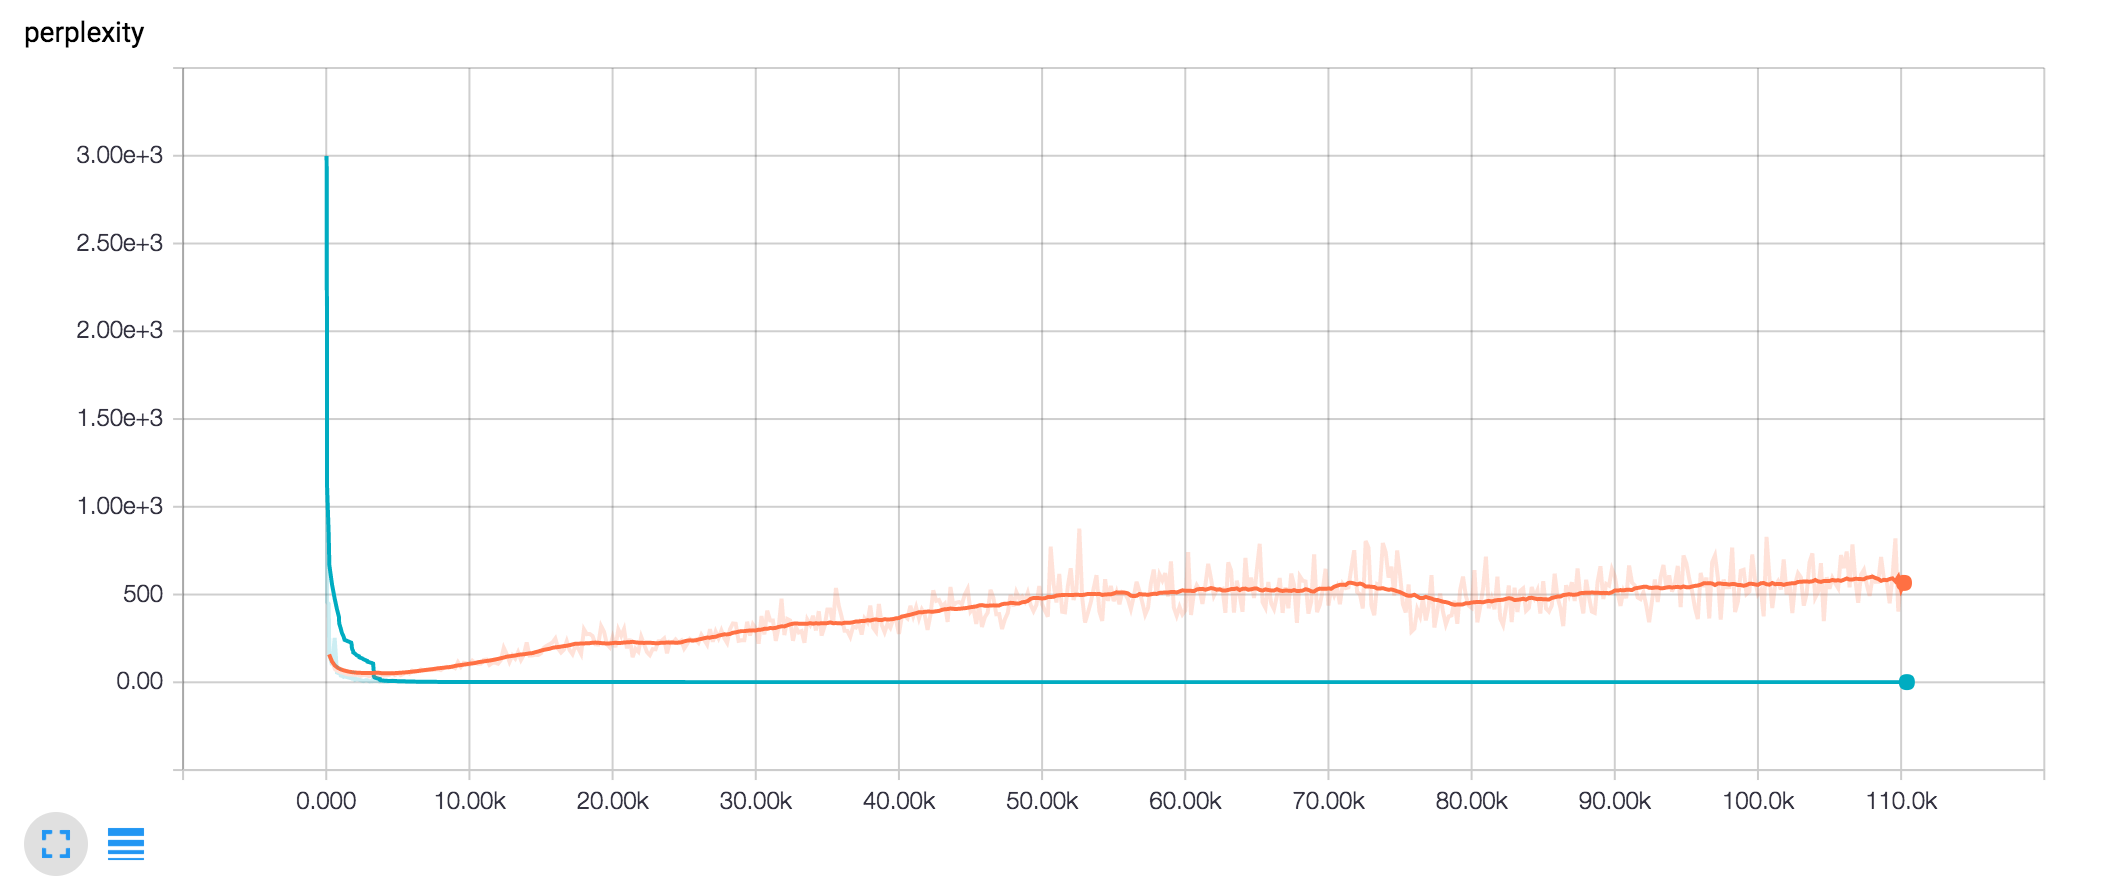

In [3]:
Image(filename='first-test-perplexity.png')